In [37]:
#Import Python packages used in the code
#Original packages by Matthias Cuntz
import time as ptime
import sys
import configparser
import os.path
import numpy as np
import pandas as pd
import pyjams as pj
import hesseflux as hf

#Additional packages by Mario Alberto Fuentes Monjaraz 
import datetime as dt
from datetime import timedelta
import altair as alt
import math
from pyproj import Proj
import matplotlib.pyplot as plt
import ee
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import folium
from folium import plugins
from IPython.display import Image
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import time 
import FFP_Python.calc_footprint_FFP_climatology as ffpmodule
import urllib.request

#Activate to visualize the plots in the jupyternotebook
# plots %matplotlib inline

In [38]:
from GppTools import Gpp as gpp

In [39]:
# ee.Authenticate() #For authentifications we require a Google Account registered in GEE (https://earthengine.google.com/)
ee.Initialize()  


In [40]:
dgpp = gpp()
dgpp.collection = 'COPERNICUS/S2_SR_HARMONIZED'
# dgpp.collection = 'MODIS/006/MOD17A2H'

# COPERNICUS_S2_L2A = 'COPERNICUS/S2_SR_HARMONIZED'        #Multi-spectral surface reflectances (https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)
# MODIS_temp        = 'MODIS/006/MOD11A1'                  #Land surface temperature (https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1)
# USAID_prec        = 'UCSB-CHG/CHIRPS/DAILY'              #InfraRed Precipitation with Station dat (https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)
# MODIS_GPP         = 'MODIS/006/MOD17A2H'                 #Gross primary productivity(https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD17A2H)
# MODIS_NPP         = 'MODIS/006/MOD17A3HGF'               #Net primary productivity (https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD17A3HGF)

dgpp.year_list = [2022,2023,2024] # [2017,2018,2019,2020,2021,2022,2023,2024]
dgpp.max_cloud_coverage   = 30
dgpp.local_cloud_coverage = 100
dgpp.ndviMask = -100
dgpp.mndviMask = -100
dgpp.bands = ['NDVI','EVI','EVI2','CLr','MNDVI','MNDWI','LSWI','NDII', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
dgpp.crs = 'EPSG:32632'
dgpp.resolution = 10
dgpp.outputdir = 'Output'

In [41]:
file_path = r'P:\11204971-eshape\Interns\5_Karisma\01-Data\Additional Sites\list_sites_without_Lonzee.xlsx'
df = pd.read_excel(file_path)


In [42]:
df['fetch']= 100 * (df['instrument_height']-df['canopy_height']*2/3)

In [43]:
df

,country code,site name,station id,main ecosystem,latitude,longitude,elevation,canopy_height,instrument_height,fetch_desired,status,snow_season,fetch
0,FR,Estrees-Mons A28,FR-EM2,croplands,49.87211,3.020650,85,0.7,2.00,100,No snow,NaN,153.333333
1,DE,Hohes Holz,DE-HoH,deciduous broadleaf forests,52.08656,11.222350,193,33.0,45.00,500,Snow coverage for some years (e.g. 2020),dec-jan,2300.000000
2,IT,Torgnon,IT-Tor,grasslands,45.84444,7.578055,2168,0.0,2.55,80,High snow coverage,nov-may,255.000000
3,FI,Hyytiala,FI-Hyy,evergreen needleleaf forests,61.84741,24.294770,181,18.0,27.00,400,High snow coverage,jan-apr,1500.000000


The maximun cloud coverage in the image is: 30
The original size of the collection is 698
The filtered size of the collection is 144


The maximun cloud coverage in the area is: 100
The original size of the collection is 144
The filtered size of the collection is 144


       Exporting: Vegetation_indices.csv


The maximun cloud coverage in the image is: 30
The original size of the collection is 348
The filtered size of the collection is 54


The maximun cloud coverage in the area is: 100
The original size of the collection is 54
The filtered size of the collection is 54


       Exporting: Vegetation_indices.csv


The maximun cloud coverage in the image is: 30
The original size of the collection is 348
The filtered size of the collection is 149


The maximun cloud coverage in the area is: 100
The original size of the collection is 149
The filtered size of the collection is 149


       Exporting: Vegetation_indices.csv


The maximun cloud coverage in the image is: 30
The original size

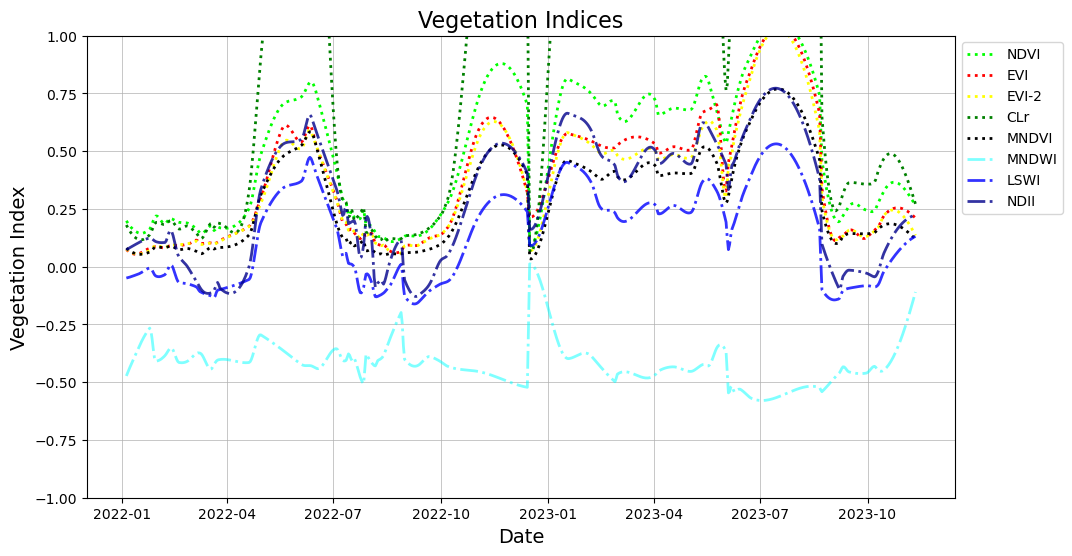

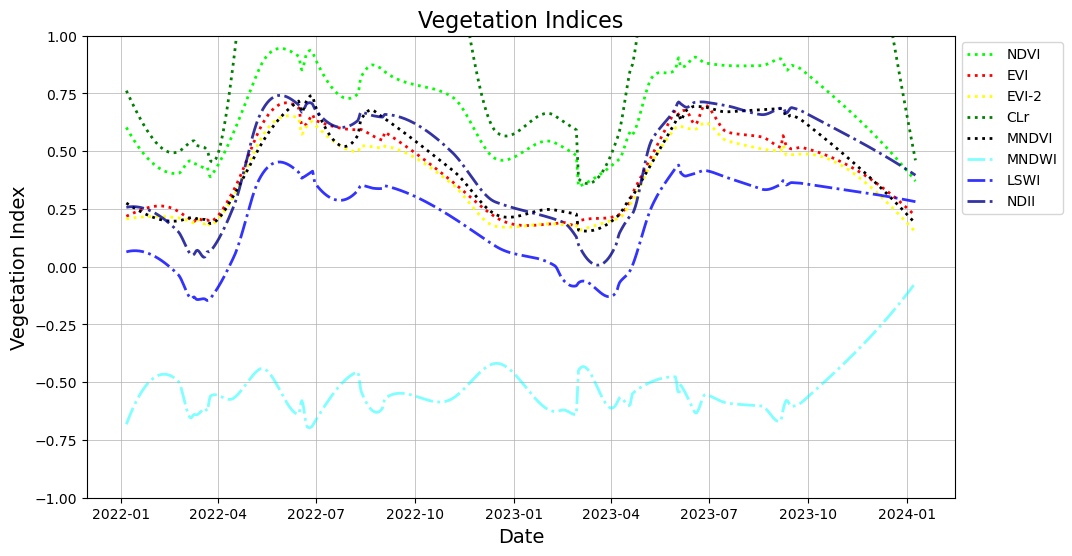

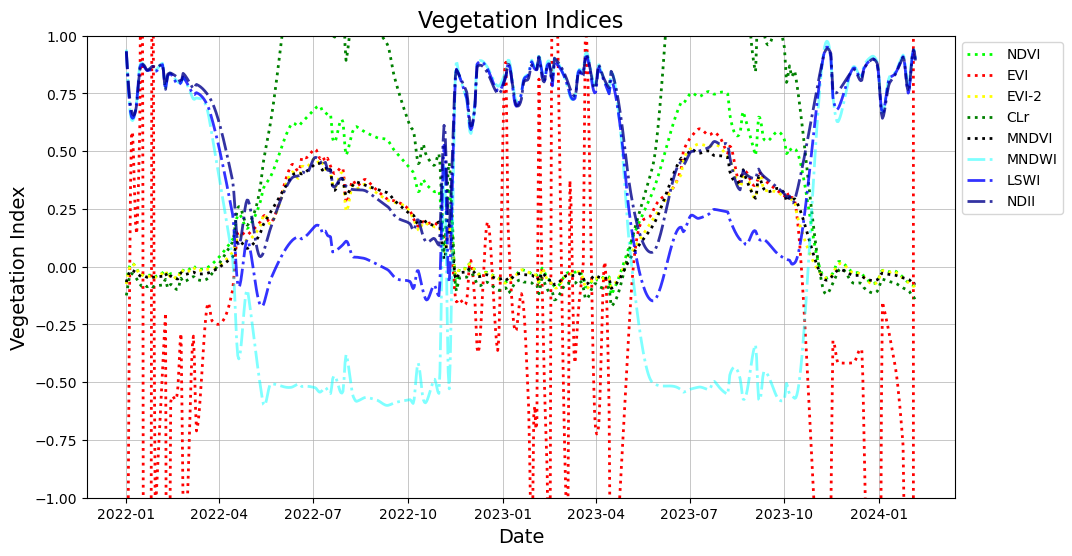

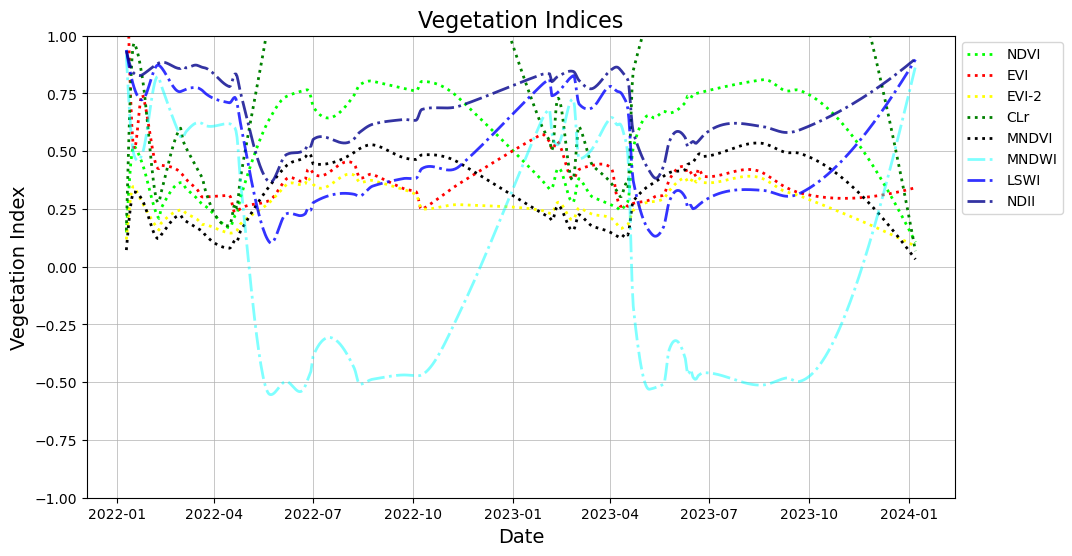

In [44]:
for index, row in df.iterrows():

    dgpp.longitude = row['longitude']
    dgpp.latitude = row['latitude']
    dgpp.ID = row['site name']

    #TODO:Integrate anenometer and displacement height in the list_sites.xlsx file to run this part
    # dgpp.instrument_height_anenometer = row['instrument_height']
    # dgpp.displacement_height = row['canopy_height']*2/3
    # fetch = 100*(dgpp.instrument_height_anenometer - dgpp.displacement_height) #Fetch to height ratio https://www.mdpi.com/2073-4433/10/6/299
    #                                                                        #https://nicholas.duke.edu/people/faculty/katul/Matlab_footprint.html 
    fetch = row['fetch_desired']
    fetch = 100
    lon_lat         =  [dgpp.longitude, dgpp.latitude]
    point = ee.Geometry.Point(lon_lat)
    aoi  = point.buffer(fetch)
    # bbox_coordinates = aoi.bounds().coordinates().get(0)
    # min_x = ee.List(ee.List(bbox_coordinates).get(0)).get(0)
    # min_y = ee.List(ee.List(bbox_coordinates).get(0)).get(1)
    # max_x = ee.List(ee.List(bbox_coordinates).get(2)).get(0)
    # max_y = ee.List(ee.List(bbox_coordinates).get(2)).get(1)
    # bbox = ee.Geometry.Rectangle([min_x, min_y, max_x, max_y]) 
    
    df_VI_export =  dgpp.calculate_VI_with_area_simplified(dgpp.collection,dgpp.year_list, aoi, dgpp.longitude, dgpp.latitude, dgpp.max_cloud_coverage, dgpp.local_cloud_coverage, dgpp.ndviMask, dgpp.mndviMask, dgpp.bands, dgpp.crs, dgpp.resolution, dgpp.ID, dgpp.outputdir)                                                                
